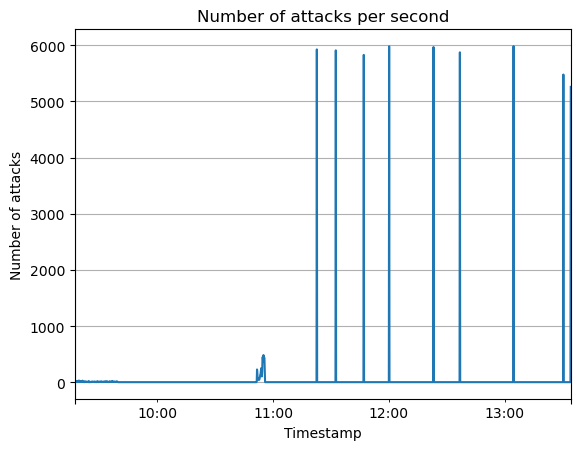

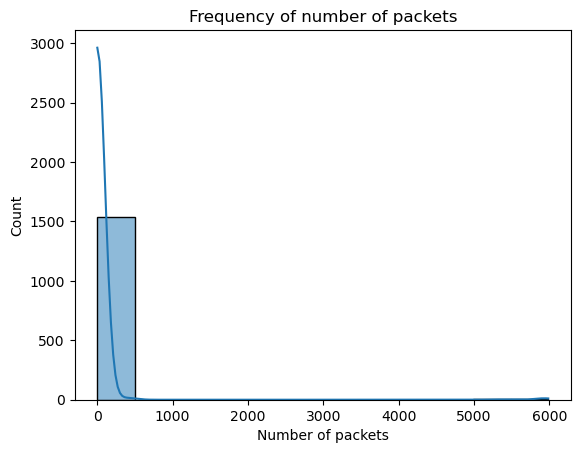

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

ddos_data = pd.read_csv('ddos_dataset.csv', low_memory=False)

operational_df = ddos_data.copy()
operational_df[' Timestamp'] = pd.to_datetime(operational_df[' Timestamp'])
operational_df.set_index(' Timestamp', inplace=True)
mask_malicious = operational_df['label'] != 'benign'
df_result = operational_df[mask_malicious].resample('10S').count()

df_result['Flow ID'].plot()
plt.xlabel('Timestamp')
plt.ylabel('Number of attacks')
plt.title('Number of attacks per second')
plt.grid()
plt.show()

plt.figure()
sns.histplot(data=df_result, x='Flow ID', kde=True)
plt.xlabel('Number of packets')
plt.title('Frequency of number of packets')
plt.show()

Let's analyze the top 5 destination IP reached by attacks

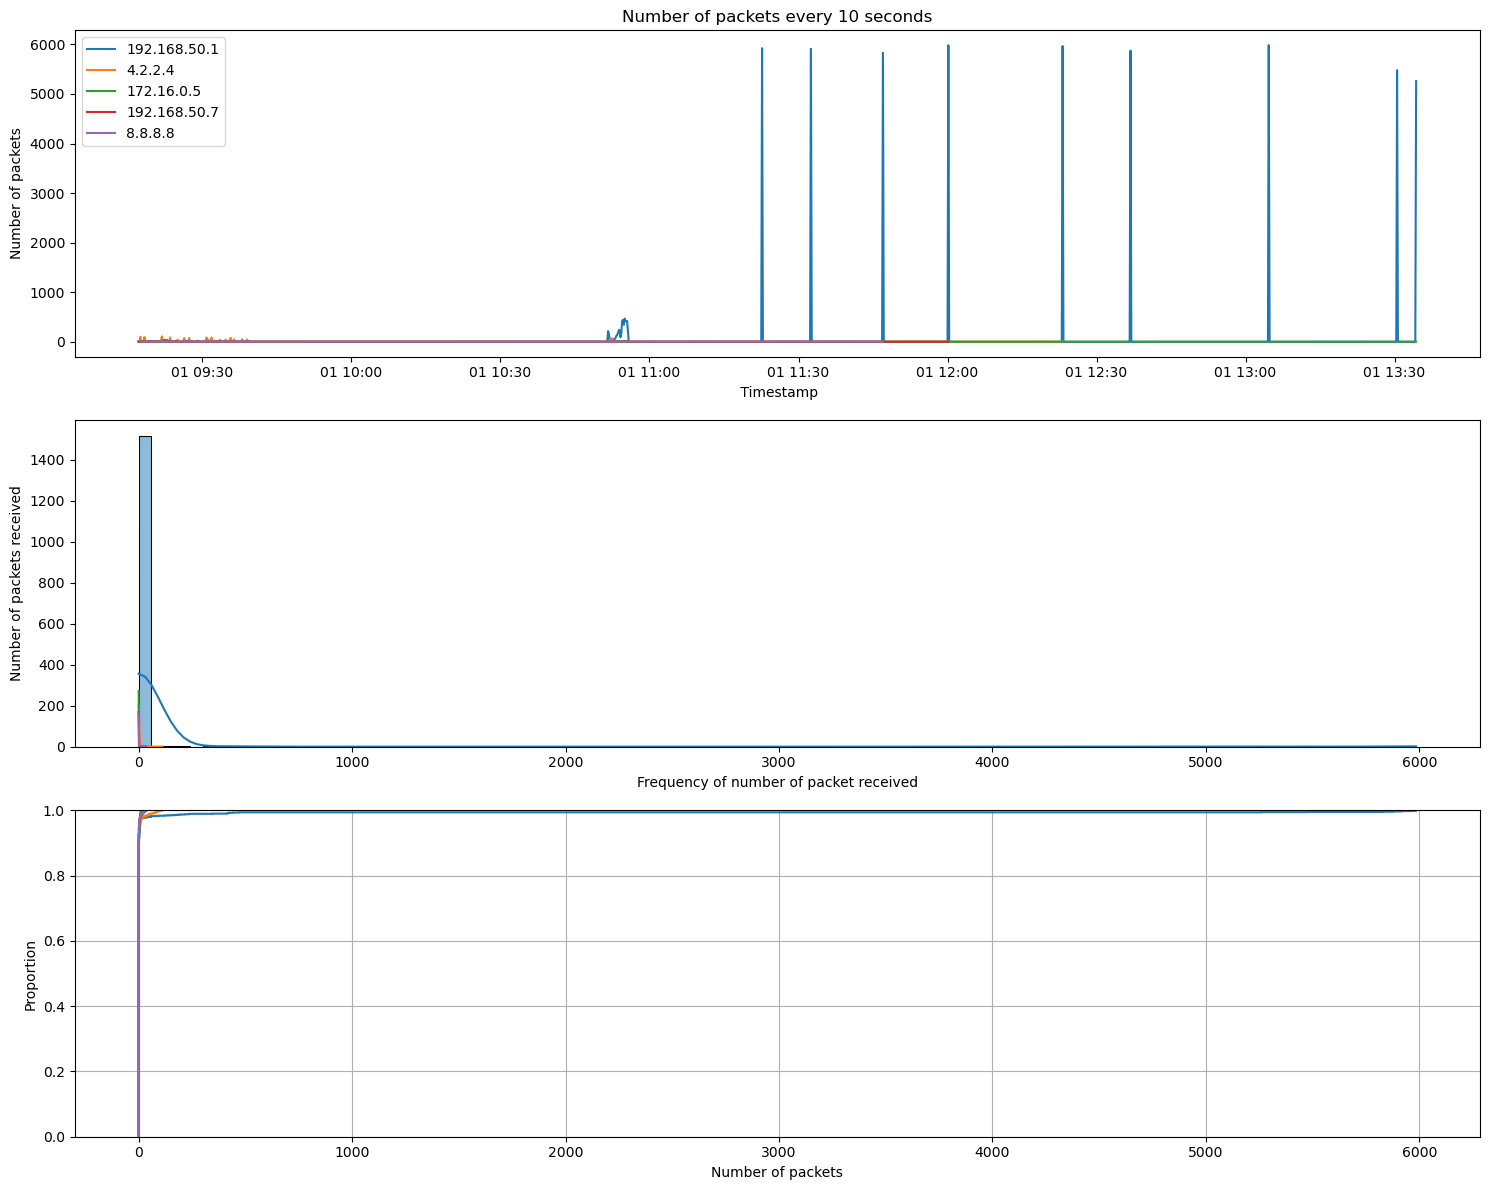

In [10]:
ip_top5 = operational_df.groupby(' Destination IP').count().sort_values(by='Flow ID', ascending=False).index[:5]
num_packets = []
t_df = operational_df.copy()
fig, ax = plt.subplots(3, 1, figsize=(15, 12))

for ip in ip_top5:
    mask_ip = t_df[' Destination IP'] == ip
    temp_df = t_df[mask_ip].resample('10S').count()
    sns.lineplot(data=temp_df, y=' Destination IP', x=' Timestamp', label=ip, ax=ax[0])
    ax[0].set_title('Number of packets every 10 seconds')
    ax[0].set_ylabel('Number of packets')

    sns.histplot(data=temp_df[' Destination IP'],  kde=True, bins=100, ax=ax[1])
    ax[1].set_ylabel('Number of packets received')
    ax[1].set_xlabel('Frequency of number of packet received')
    #ask for ecdfplot strange plot
    sns.ecdfplot(data=temp_df[' Destination IP'],  ax=ax[2])
    ax[2].set_xlabel('Number of packets')
    plt.grid()

plt.tight_layout()
plt.show()

Since the top IP destination has received a lot more packets in respect of the other, let's exclude it and analyze the other 4 for a clear representation of also the othre targeted IP

 Protocol
0        18
6     11857
17    46706
Name: Flow ID, dtype: int64


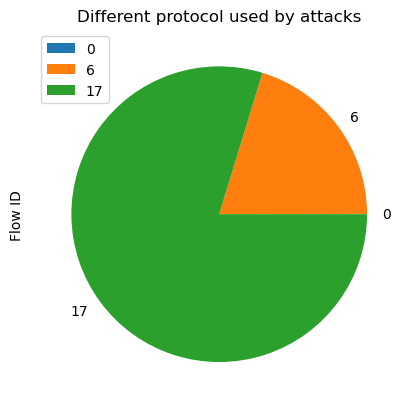

In [11]:
malicious_df = operational_df[mask_malicious].copy()
protocol_df = malicious_df.groupby(' Protocol').count()['Flow ID']
protocol_df.plot(kind='pie', title='Different protocol used by attacks')
plt.legend()
print(protocol_df)

Even if the protol 0 seems to be not used, it is indeed. This visualization is due to the fact that the count for each protocol is:<br>
0        18, <br>
6     11857, <br>
17    46706 <br>

<AxesSubplot: xlabel='label'>

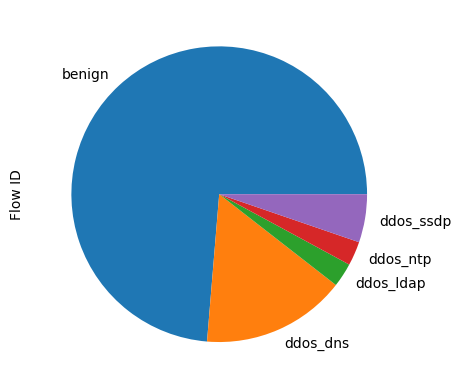

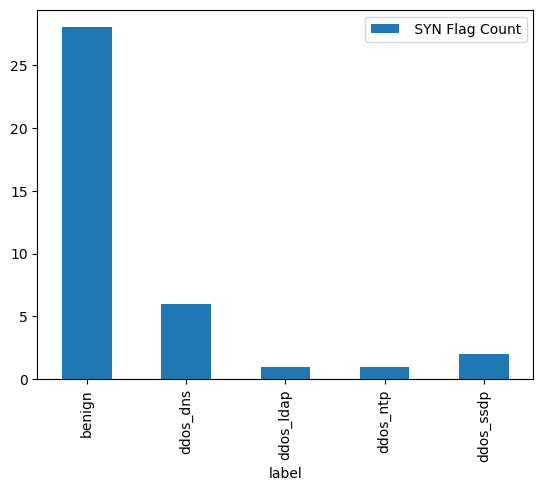

In [6]:
mask_SYN = operational_df[' SYN Flag Count'] != 0
SYN_df = operational_df[mask_SYN].groupby('label').count()['Flow ID']
SYN_df.plot(kind='pie')
at_SYN_df = operational_df[mask_SYN]
at_SYN_df[[' SYN Flag Count', 'label']].groupby('label').count().plot(kind='bar')

Now it's time to analyze the kind of attack or data flow characterized by the SYN flag high in the TCP protocol

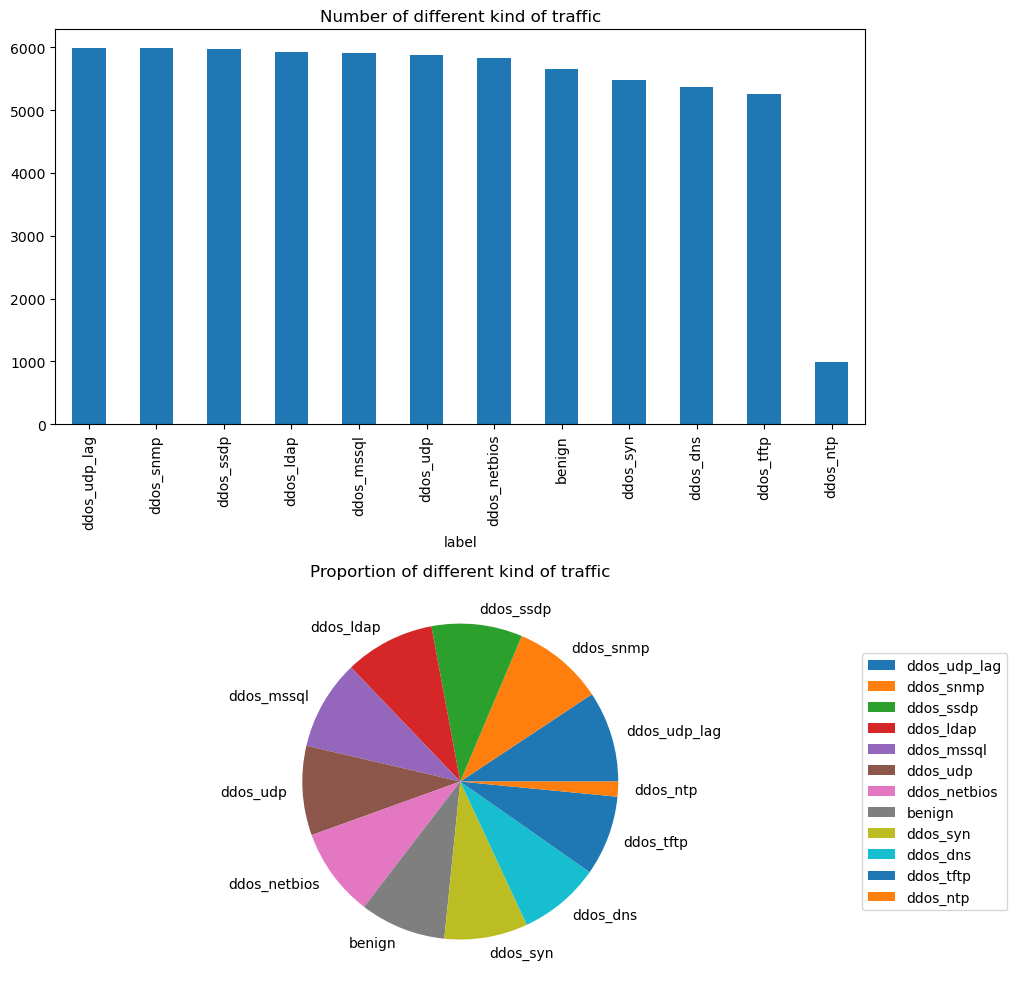

In [12]:
df_attacks = operational_df.groupby('label').count().sort_values(by='Flow ID', ascending=False)
attacks = df_attacks.index
fig, ax = plt.subplots(2,1)
df_attacks['Flow ID'].plot(kind='bar', title='Number of different kind of traffic', ax=ax[0], figsize=(10,2))
df_attacks.plot(kind='pie', y='Flow ID', ax=ax[1], title='Proportion of different kind of traffic', figsize=(10,10))
ax[1].legend(loc='center left', bbox_to_anchor=(1.5, 0.5))
ax[1].set_ylabel('')

plt.tight_layout()

<AxesSubplot: title={'center': 'Top 10 Flow ID number of packets'}, xlabel='Flow ID'>

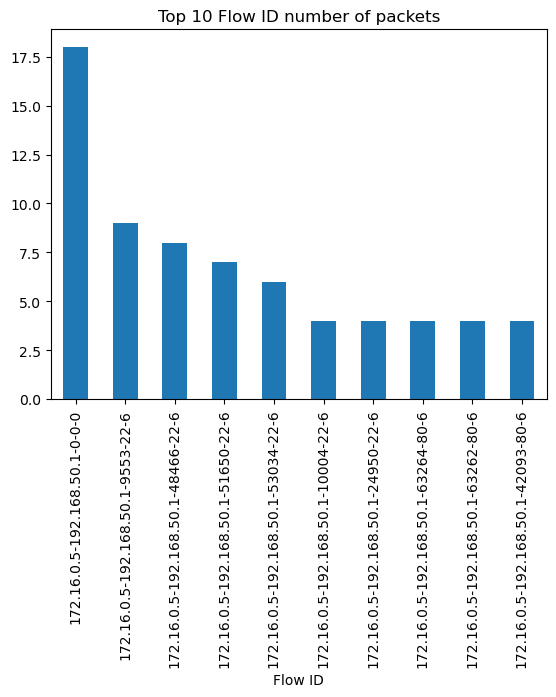

In [14]:
mask_bening = operational_df['label'] != 'benign'
df_flow_id = operational_df[mask_bening].groupby('Flow ID').count().sort_values(by=' Source IP', ascending=False)[:10]
df_flow_id[' Source IP'].plot(kind='bar', title='Top 10 Flow ID number of packets')

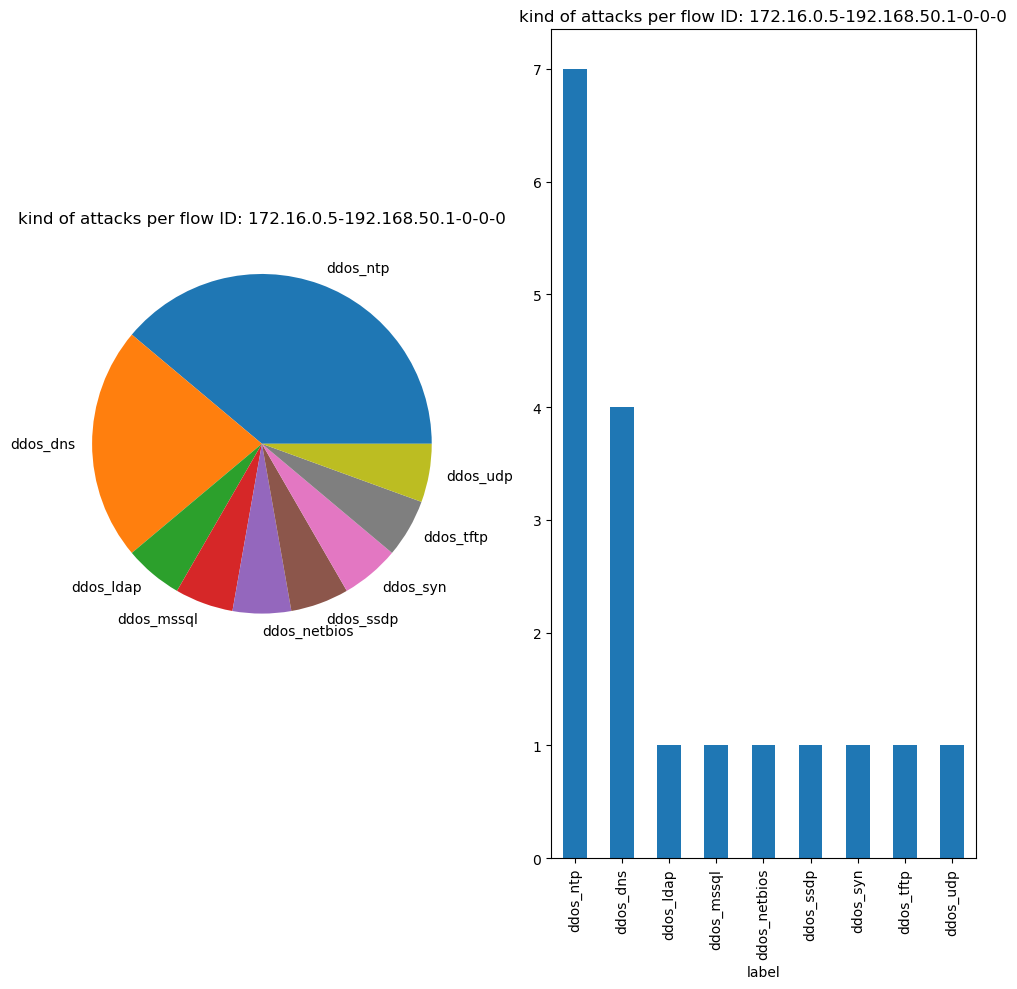

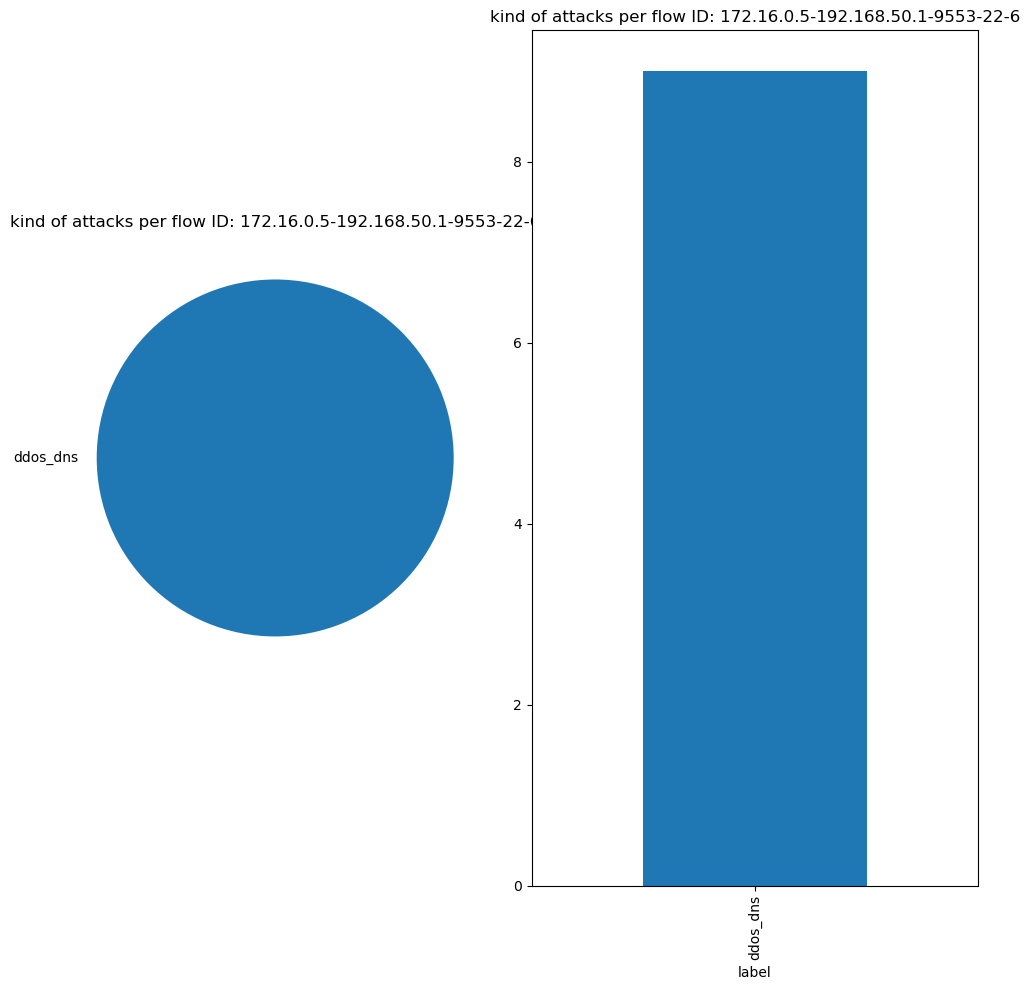

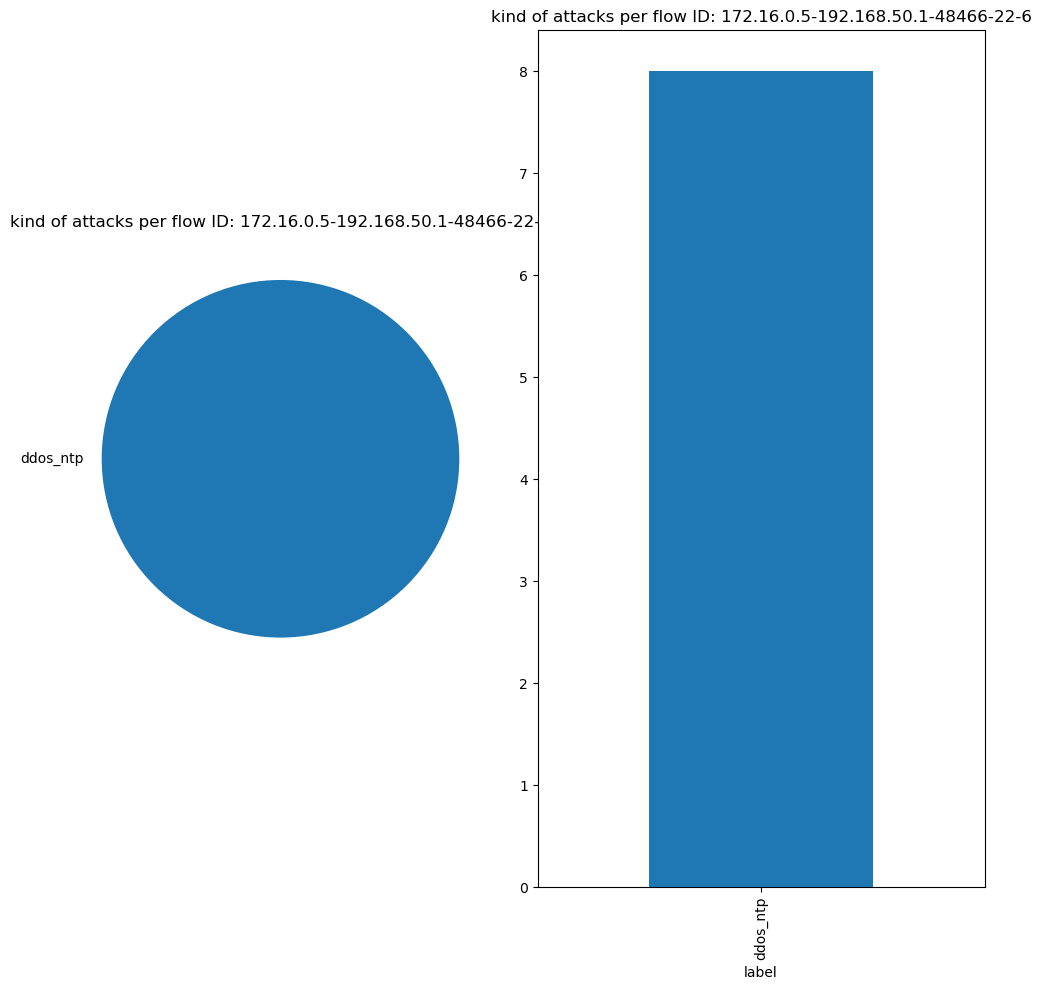

In [15]:
for i, index in enumerate(df_flow_id.index[:3]):
    fig, ax = plt.subplots(1,2, figsize=(10,10))
    mask_index = operational_df['Flow ID'] == index
    df_plot = operational_df[mask_index].groupby('label').count().sort_values(by='Flow ID', ascending=False)['Flow ID']
    df_plot.plot(kind='pie', title= f'kind of attacks per flow ID: {index}', ax=ax[0])
    ax[0].set_ylabel('')
    df_plot.plot(kind='bar', title= f'kind of attacks per flow ID: {index}', ax=ax[1])
    plt.tight_layout()



Analysis of the top 10 common link (Flow ID, Source Port, Destination Port) and the relative attack (the benign flow has been removed) based on the number of packets exchanged

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


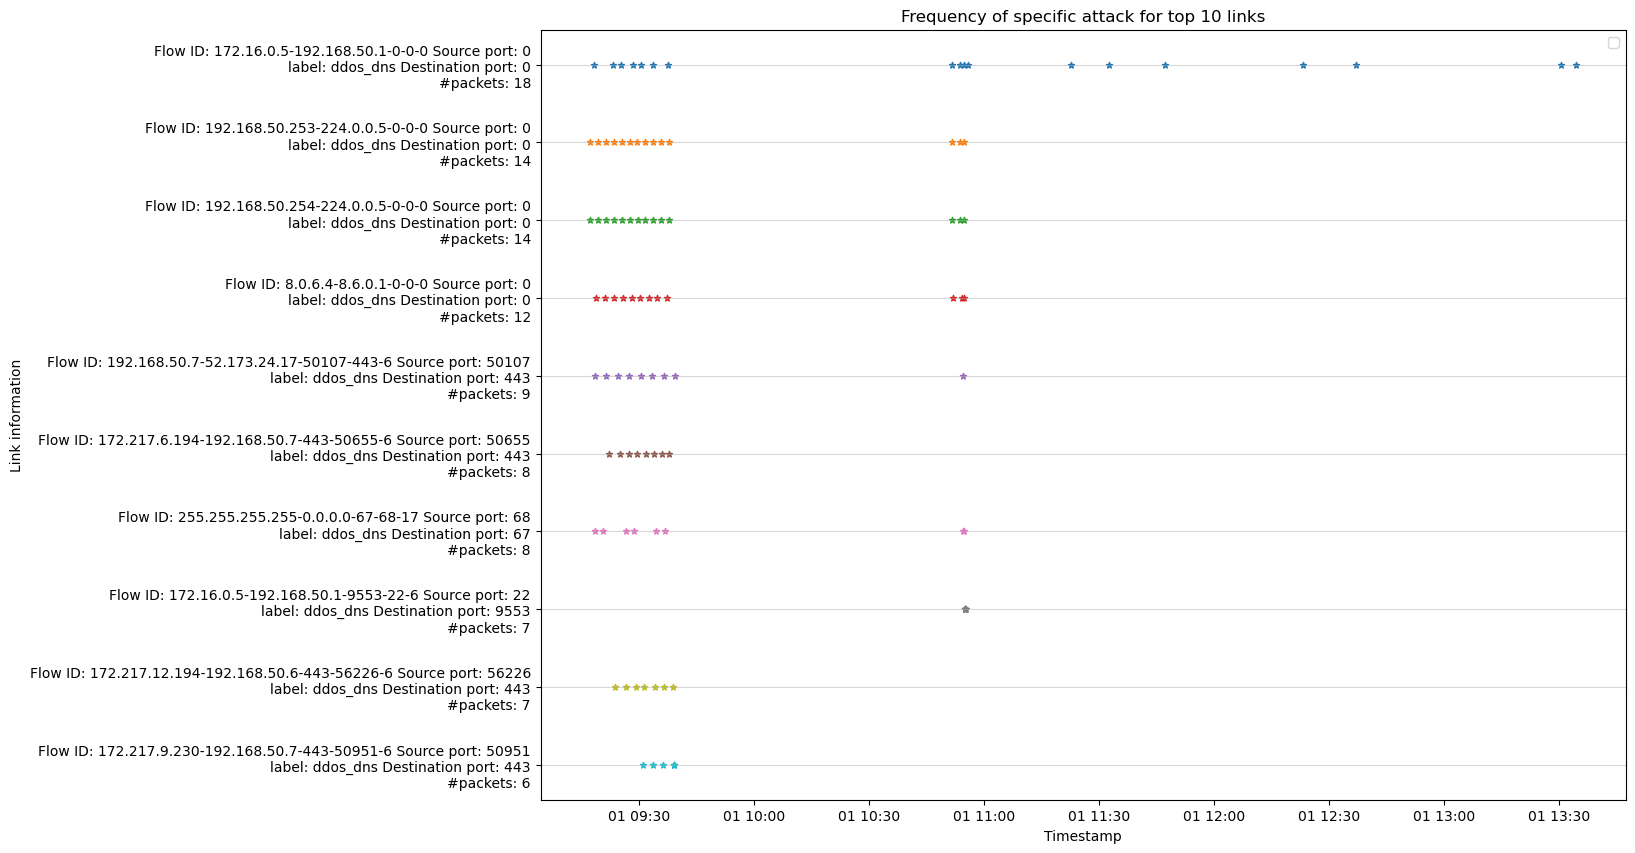

In [58]:
top_10_link = operational_df[operational_df['label'] != 'benign'].groupby(['Flow ID', 'label', ' Source Port', ' Destination Port']).count().sort_values(by=' Source IP', ascending=False).index[:10]
plt.figure(figsize=(14, 10))
ytick_labels = []
for n, link in enumerate(top_10_link):
    flow_id = link[0]
    flow_type = link[1]
    src_port = link[2]
    dst_port = link[3]
    df_link = operational_df[
        (operational_df['Flow ID'] == flow_id) &
        (operational_df[' Source Port'] == src_port) &
        (operational_df['label'] == flow_type) &
        (operational_df[ ' Destination Port'] == dst_port)
    ]
    plt.scatter(
        df_link.index,
        [10-n for _ in range(len(df_link))],
        s = 20, 
        marker = '*'
    )
    # create the label of each link for y-axis
    ytick_label = f'Flow ID: {flow_id} ' + \
                  f'Source port: {src_port}\n' + \
                  f'label: {flow_type} ' + \
                  f'Destination port: {dst_port}\n' + \
                  f'#packets: {len(df_link)}'
    ytick_labels.append(ytick_label)
plt.xlabel('Timestamp') 
plt.ylabel('Link information')
# the first list the the location of the label
# the second list is the label you want to assign to each location
plt.yticks([x for x in range(10,0,-1)], ytick_labels) 
plt.title('Frequency of specific attack for top 10 links')
plt.grid(axis='y', alpha=0.5)
plt.legend()
plt.show()

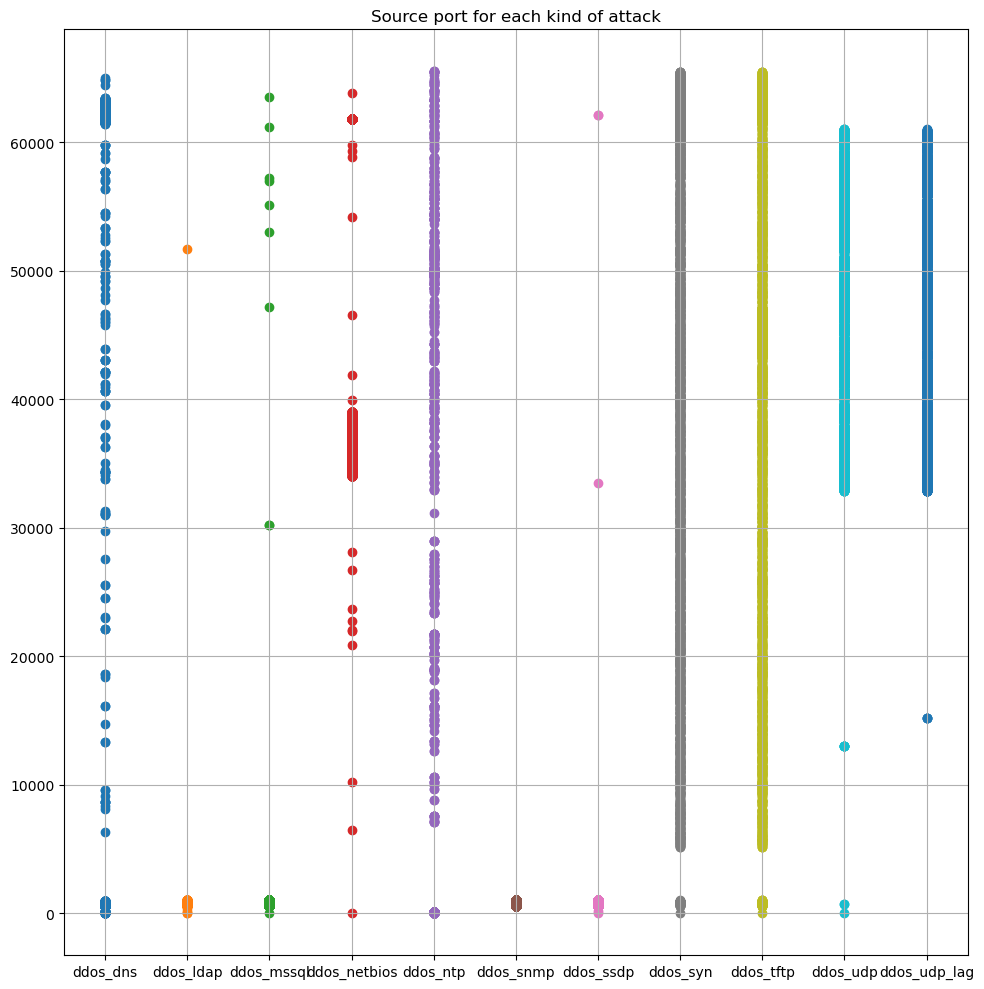

In [68]:
operational_df = ddos_data.copy()
operational_df[' Timestamp'] = pd.to_datetime(operational_df[' Timestamp'])
operational_df.set_index(' Timestamp', inplace=True)
mask_malicious = operational_df['label'] != 'benign'
df_result = operational_df[mask_malicious]
ax, figure = plt.subplots(figsize=(10,10))
labels = df_result.groupby('label').count().index
for attack in labels:
    mask_at = df_result['label'] == attack
    plt.scatter(data=df_result[mask_at], x='label', y=' Source Port')
plt.title('Source port for each kind of attack')
plt.grid()
plt.tight_layout()
plt.show()
    

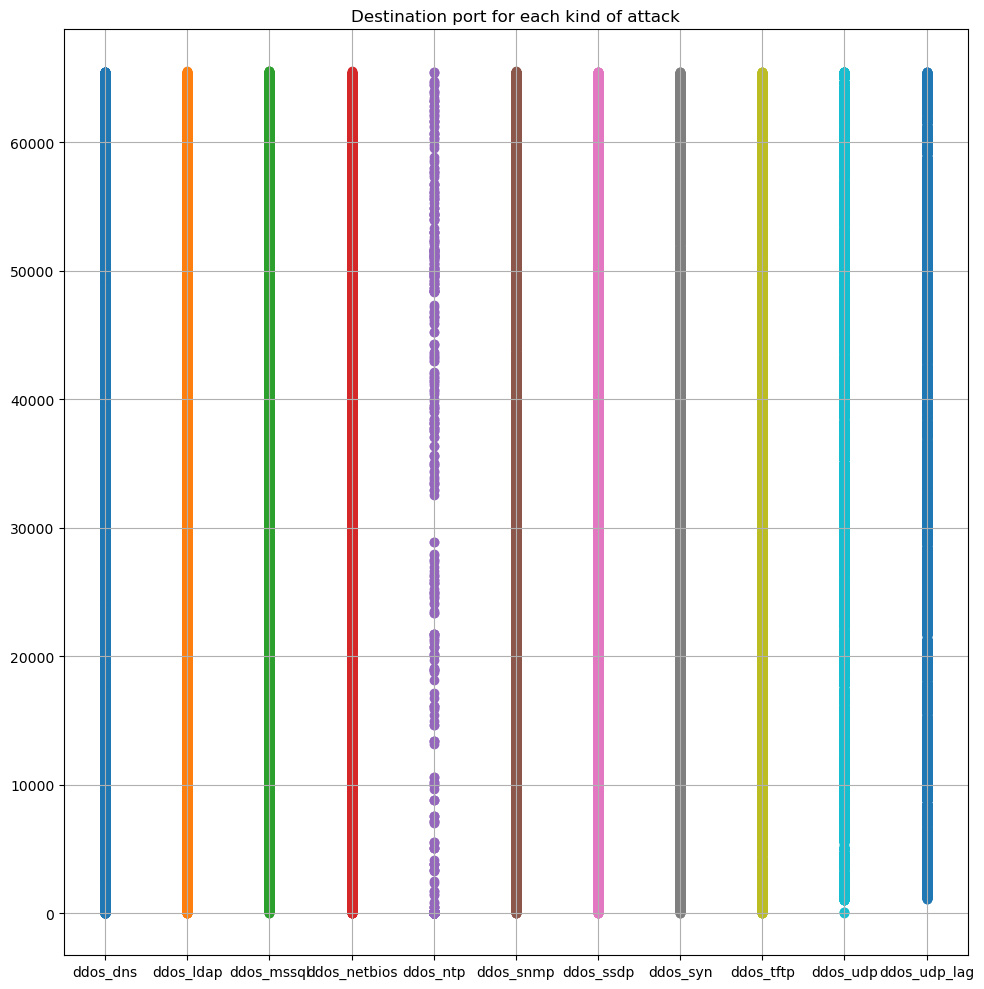

In [70]:
operational_df = ddos_data.copy()
operational_df[' Timestamp'] = pd.to_datetime(operational_df[' Timestamp'])
operational_df.set_index(' Timestamp', inplace=True)
mask_malicious = operational_df['label'] != 'benign'
df_result = operational_df[mask_malicious]
ax, figure = plt.subplots(figsize=(10,10))
labels = df_result.groupby('label').count().index
for attack in labels:
    mask_at = df_result['label'] == attack
    plt.scatter(data=df_result[mask_at], x='label', y=' Destination Port')
plt.title('Destination port for each kind of attack')
plt.grid()
plt.tight_layout()
plt.show()
    

Evauluating Packet length for each different kind of flow (attack or benign) 

<AxesSubplot: xlabel='label'>

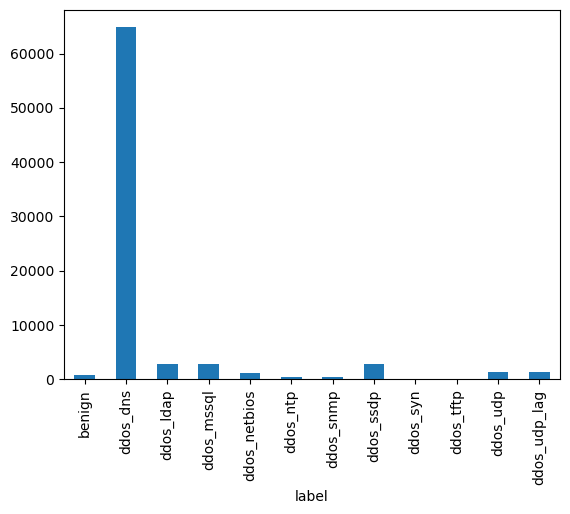

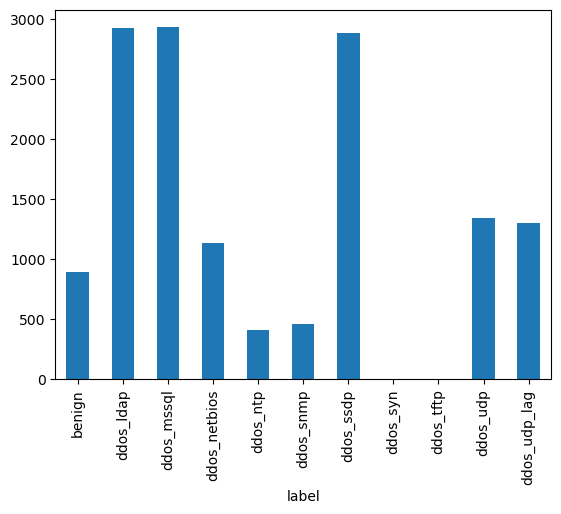

In [84]:
fig, ax = plt.subplots()
grouped_df = operational_df.groupby('label')
grouped_df['Total Length of Fwd Packets'].mean().plot(kind='bar')
fig, ax = plt.subplots()
grouped_df = operational_df[operational_df['label'] != 'ddos_dns'].groupby('label')
grouped_df['Total Length of Fwd Packets'].mean().plot(kind='bar')


PCA 

/tmp/ipykernel_9885/4215780235.py:8: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr().abs().round(2)


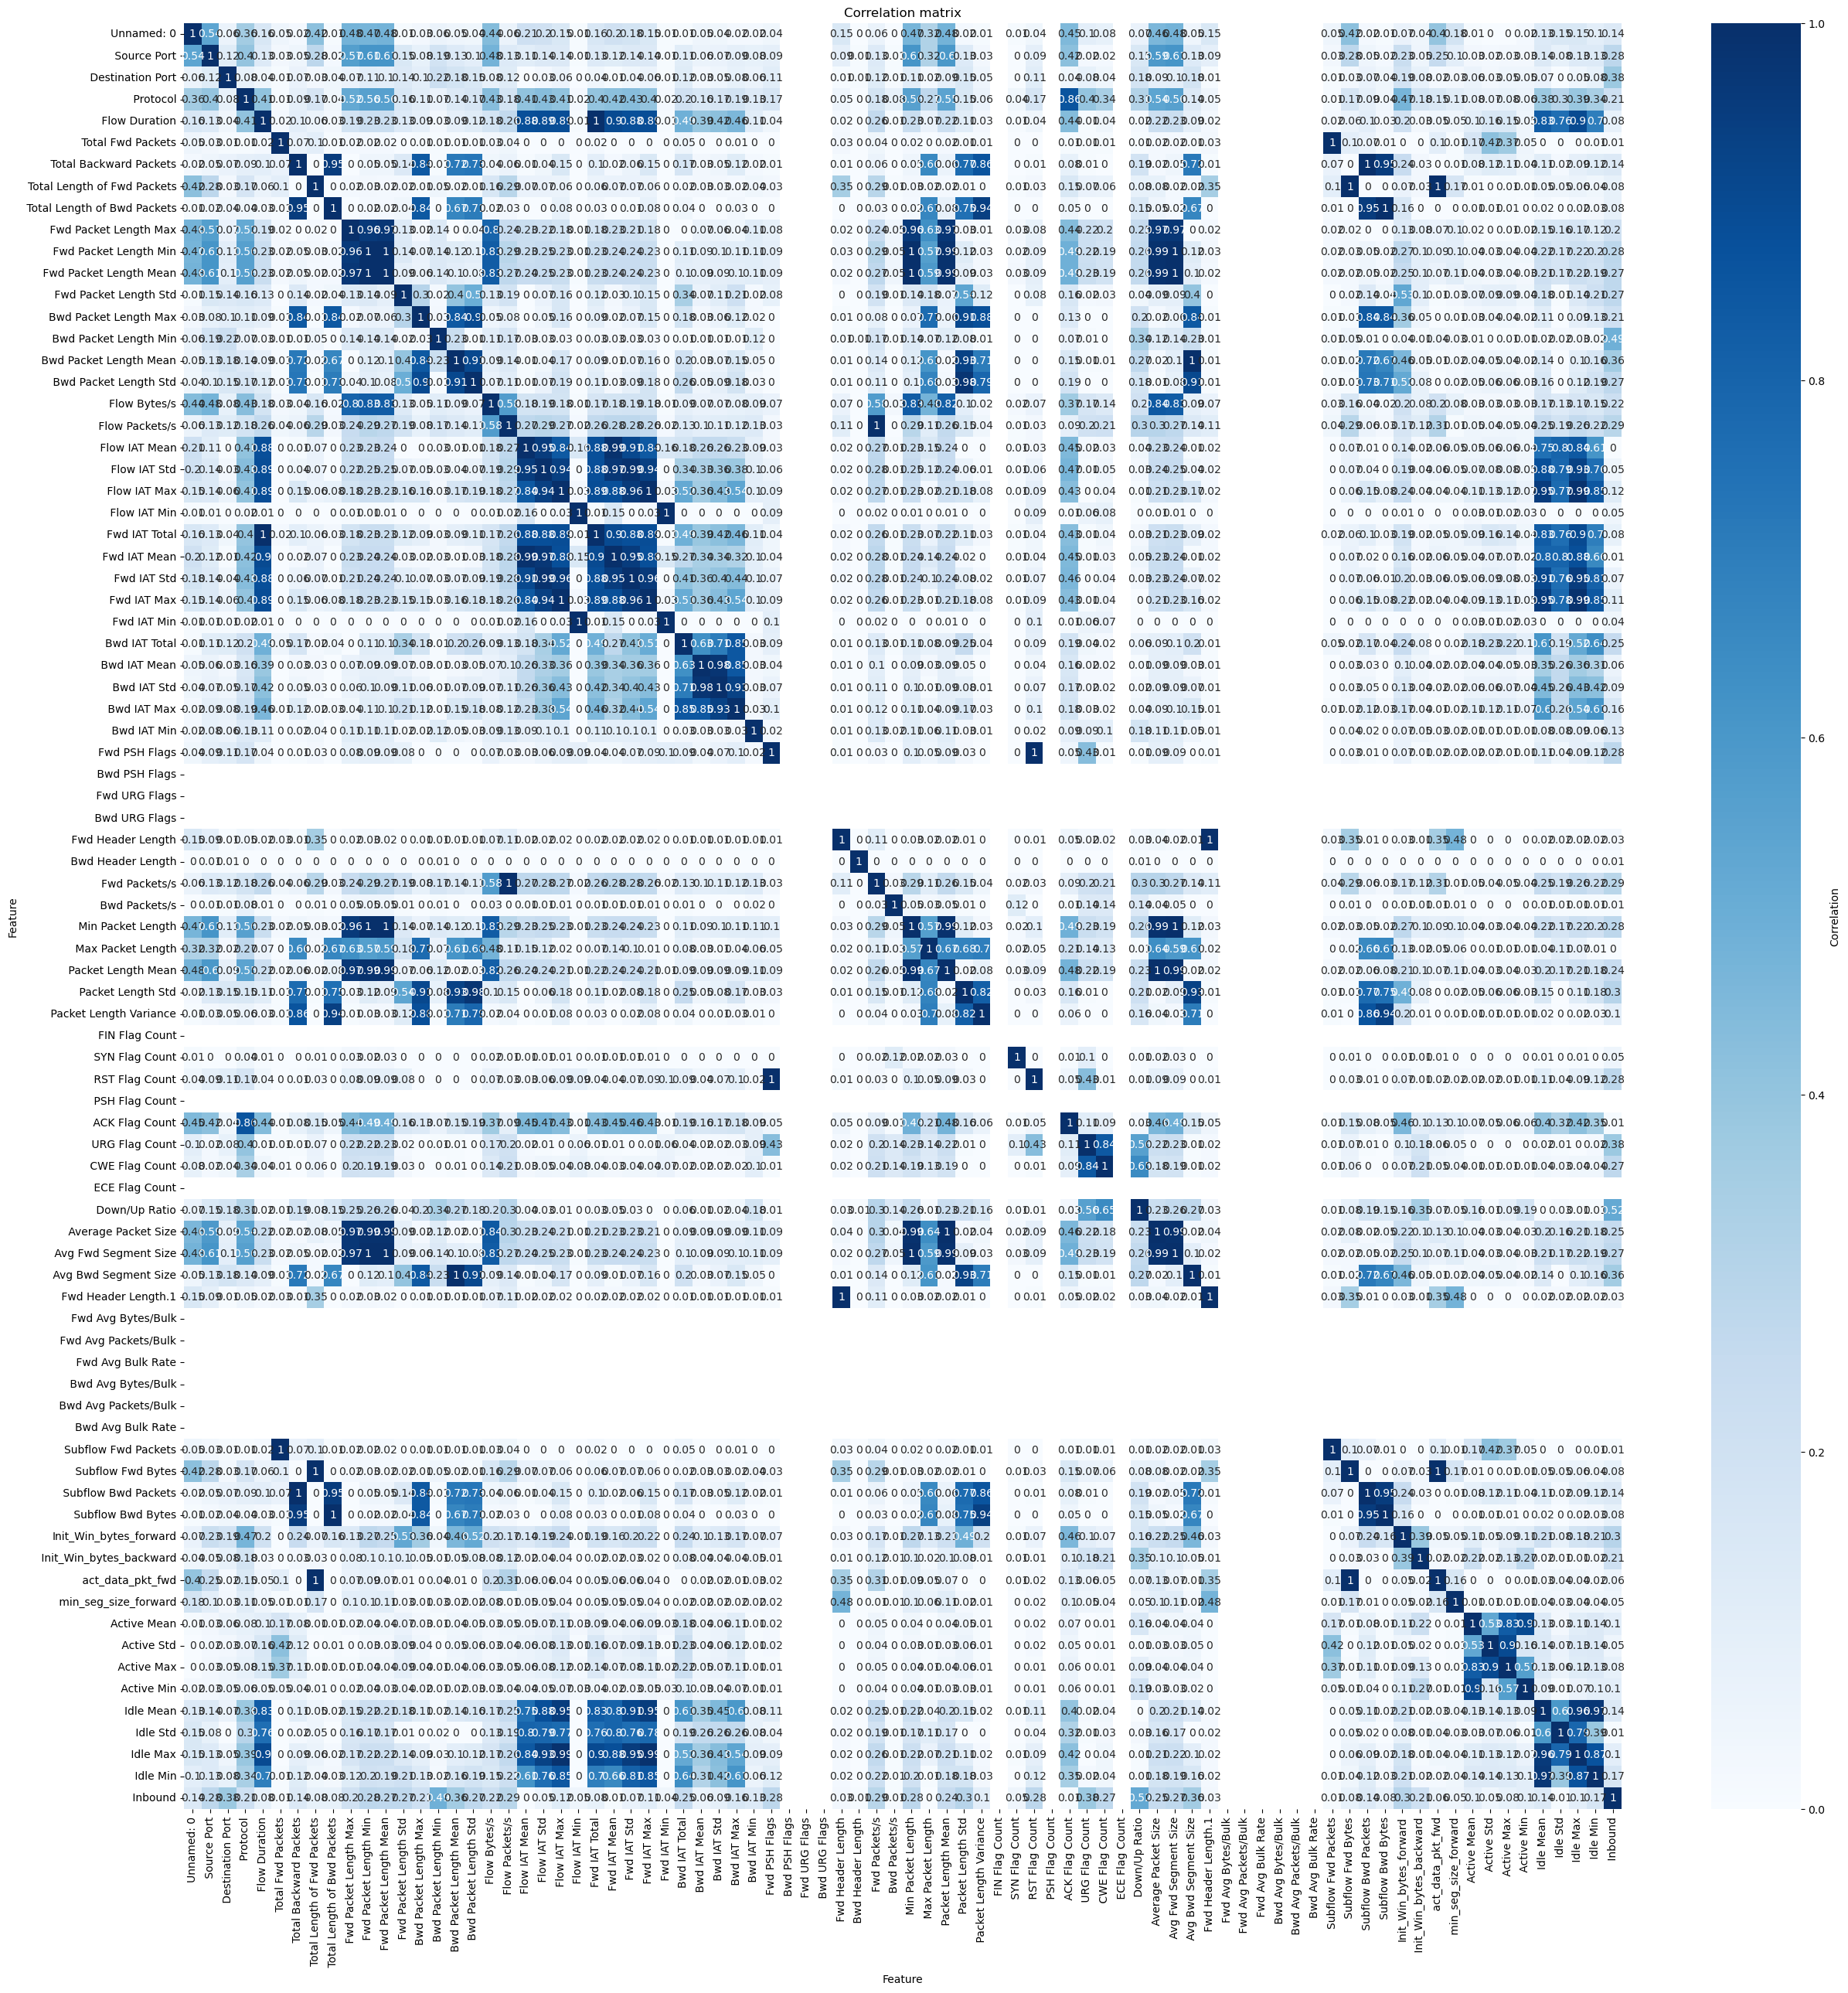

In [69]:
from sklearn.preprocessing import StandardScaler
df = ddos_data.copy()
df.set_index(' Timestamp', inplace=True)
scaler = StandardScaler()
column_to_remove = ['Flow ID', ' Source IP', ' Destination IP', 'SimillarHTTP', 'label']
df[df.columns.drop(column_to_remove)] = scaler.fit_transform(df[df.columns.drop(column_to_remove)])
df_scaled = df.copy()
correlation_matrix = df.corr().abs().round(2)
plt.figure(figsize=(30,30))
sns.heatmap(correlation_matrix, cmap='Blues', annot=True, vmin=0, vmax=1, cbar_kws={'label':'Correlation'})
plt.xlabel('Feature')
plt.ylabel('Feature')
plt.title('Correlation matrix')
plt.show()

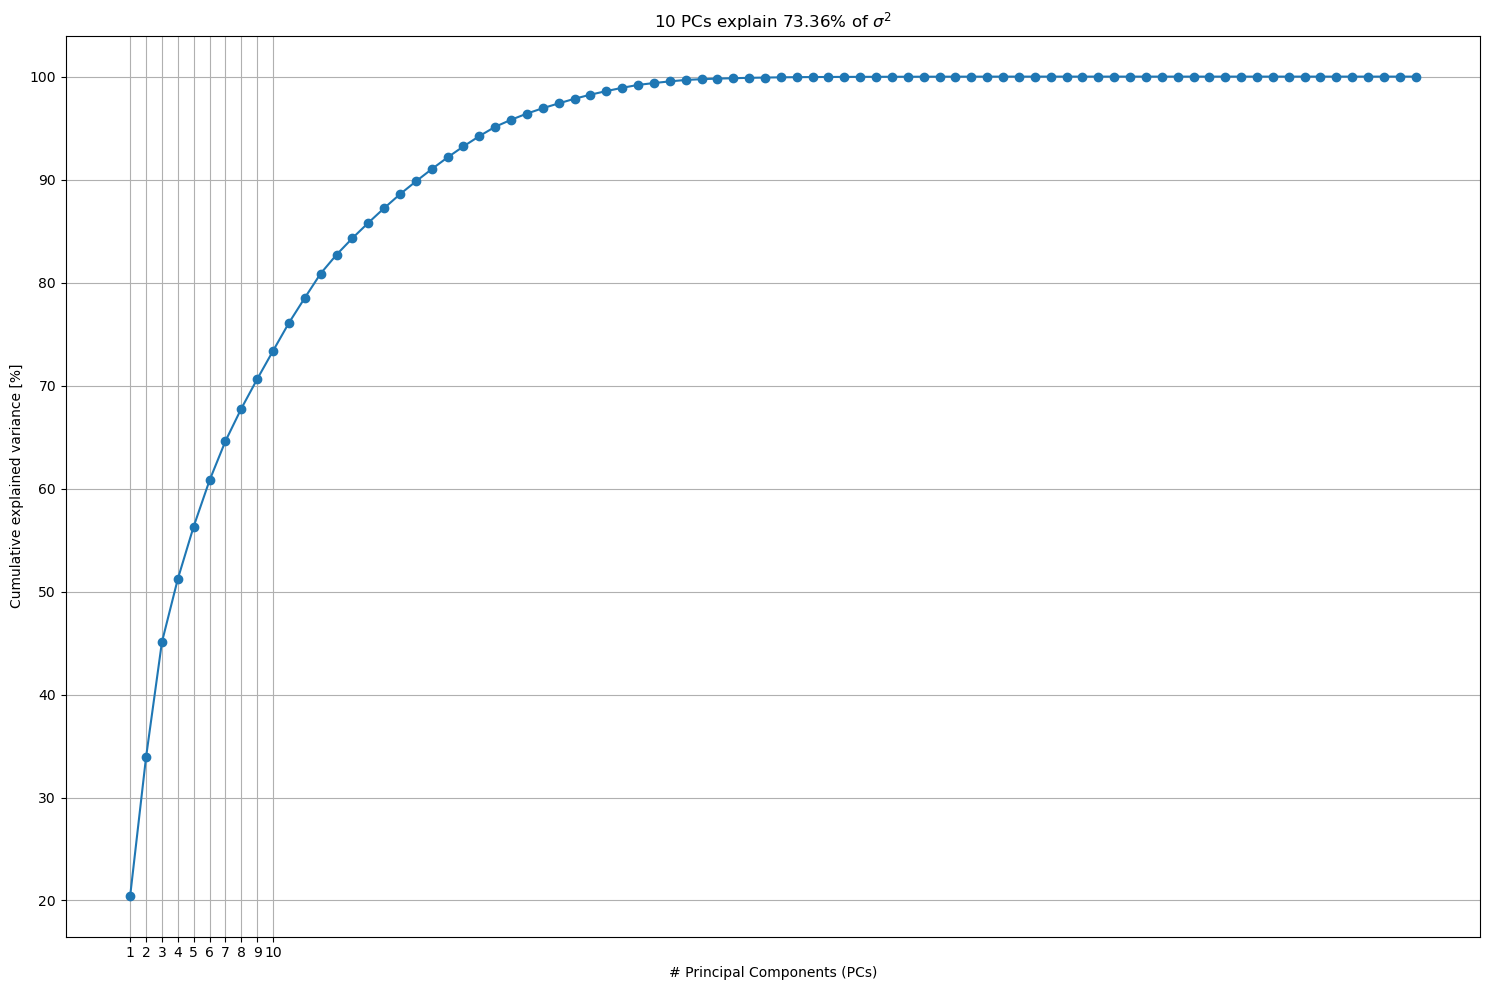

In [32]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np

pca = PCA(random_state=15)
pca.fit(df_scaled.drop(columns=['label', 'Flow ID', ' Source IP', ' Destination IP', 'SimillarHTTP']))

explained_variance = pca.explained_variance_ratio_
cumul_exp_var = np.cumsum(explained_variance)
perc_cumul_exp_var = cumul_exp_var*100

plt.figure(figsize=(15,10))
plt.plot(perc_cumul_exp_var, marker='o')
plt.xlabel('# Principal Components (PCs)')
plt.ylabel('Cumulative explained variance [%]')
plt.xticks([i for i in range(10)], [i for i in range (1,11)])
plt.grid()
plt.title(f'10 PCs explain {round(perc_cumul_exp_var[9], 2)}% of $\sigma^2$')
plt.tight_layout()
plt.show()

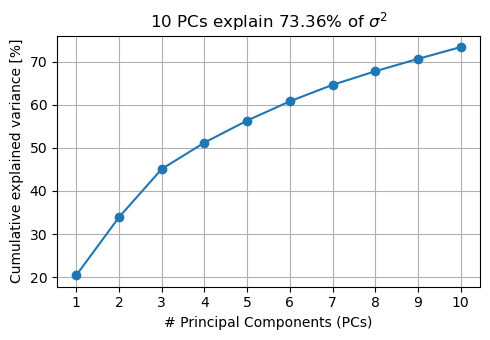

In [33]:
pca = PCA(n_components=10, random_state=15)
pca.fit(df_scaled.drop(columns=['label', 'Flow ID', ' Source IP', ' Destination IP', 'SimillarHTTP']))
pca_result = pca.transform(df_scaled.drop(columns=['label', 'Flow ID', ' Source IP', ' Destination IP', 'SimillarHTTP']))

pca_df = pd.DataFrame(pca_result, columns=['c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10'])
explained_variance = pca.explained_variance_ratio_

# evaluate the total dataset variability while increasing the variables
cumul_exp_var = np.cumsum(explained_variance)

# percentage value to better understand the best number of components
perc_cumul_exp_var = cumul_exp_var * 100

# make the plot of cumulative explained variance wrt number of components
plt.figure(figsize=(5, 3.5))
plt.plot(perc_cumul_exp_var, marker='o')
plt.xlabel('# Principal Components (PCs)')
plt.ylabel('Cumulative explained variance [%]')
plt.xticks([i for i in range(10)], [i for i in range(1,11)])
plt.grid()
plt.title(f'10 PCs explain {round(perc_cumul_exp_var[9], 2)}% of $\sigma^2$')
plt.tight_layout()
plt.show()

                        PC1       PC2       PC3       PC4       PC5       PC6  \
Unnamed: 0         0.353241 -0.240036  0.264178 -0.470789 -0.182163  0.286577   
 Source Port       0.429479 -0.150767  0.459339 -0.312597 -0.003748  0.093349   
 Destination Port -0.139581 -0.095131 -0.126765 -0.014922 -0.209436  0.185239   
 Protocol         -0.654023  0.116514 -0.259375  0.198527 -0.083779  0.053788   
 Flow Duration     0.814738 -0.040226 -0.454366  0.015406 -0.062428  0.034878   
...                     ...       ...       ...       ...       ...       ...   
Idle Mean          0.818112  0.001564 -0.458830  0.035124  0.018295 -0.042633   
 Idle Std          0.639265 -0.111872 -0.411131 -0.011446 -0.172664  0.038493   
 Idle Max          0.840614 -0.039268 -0.488759  0.021799 -0.048873 -0.016135   
 Idle Min          0.739584  0.040144 -0.399310  0.044879  0.077331 -0.063711   
 Inbound          -0.294167 -0.156557 -0.313210 -0.025395 -0.413822  0.434661   

                        PC7

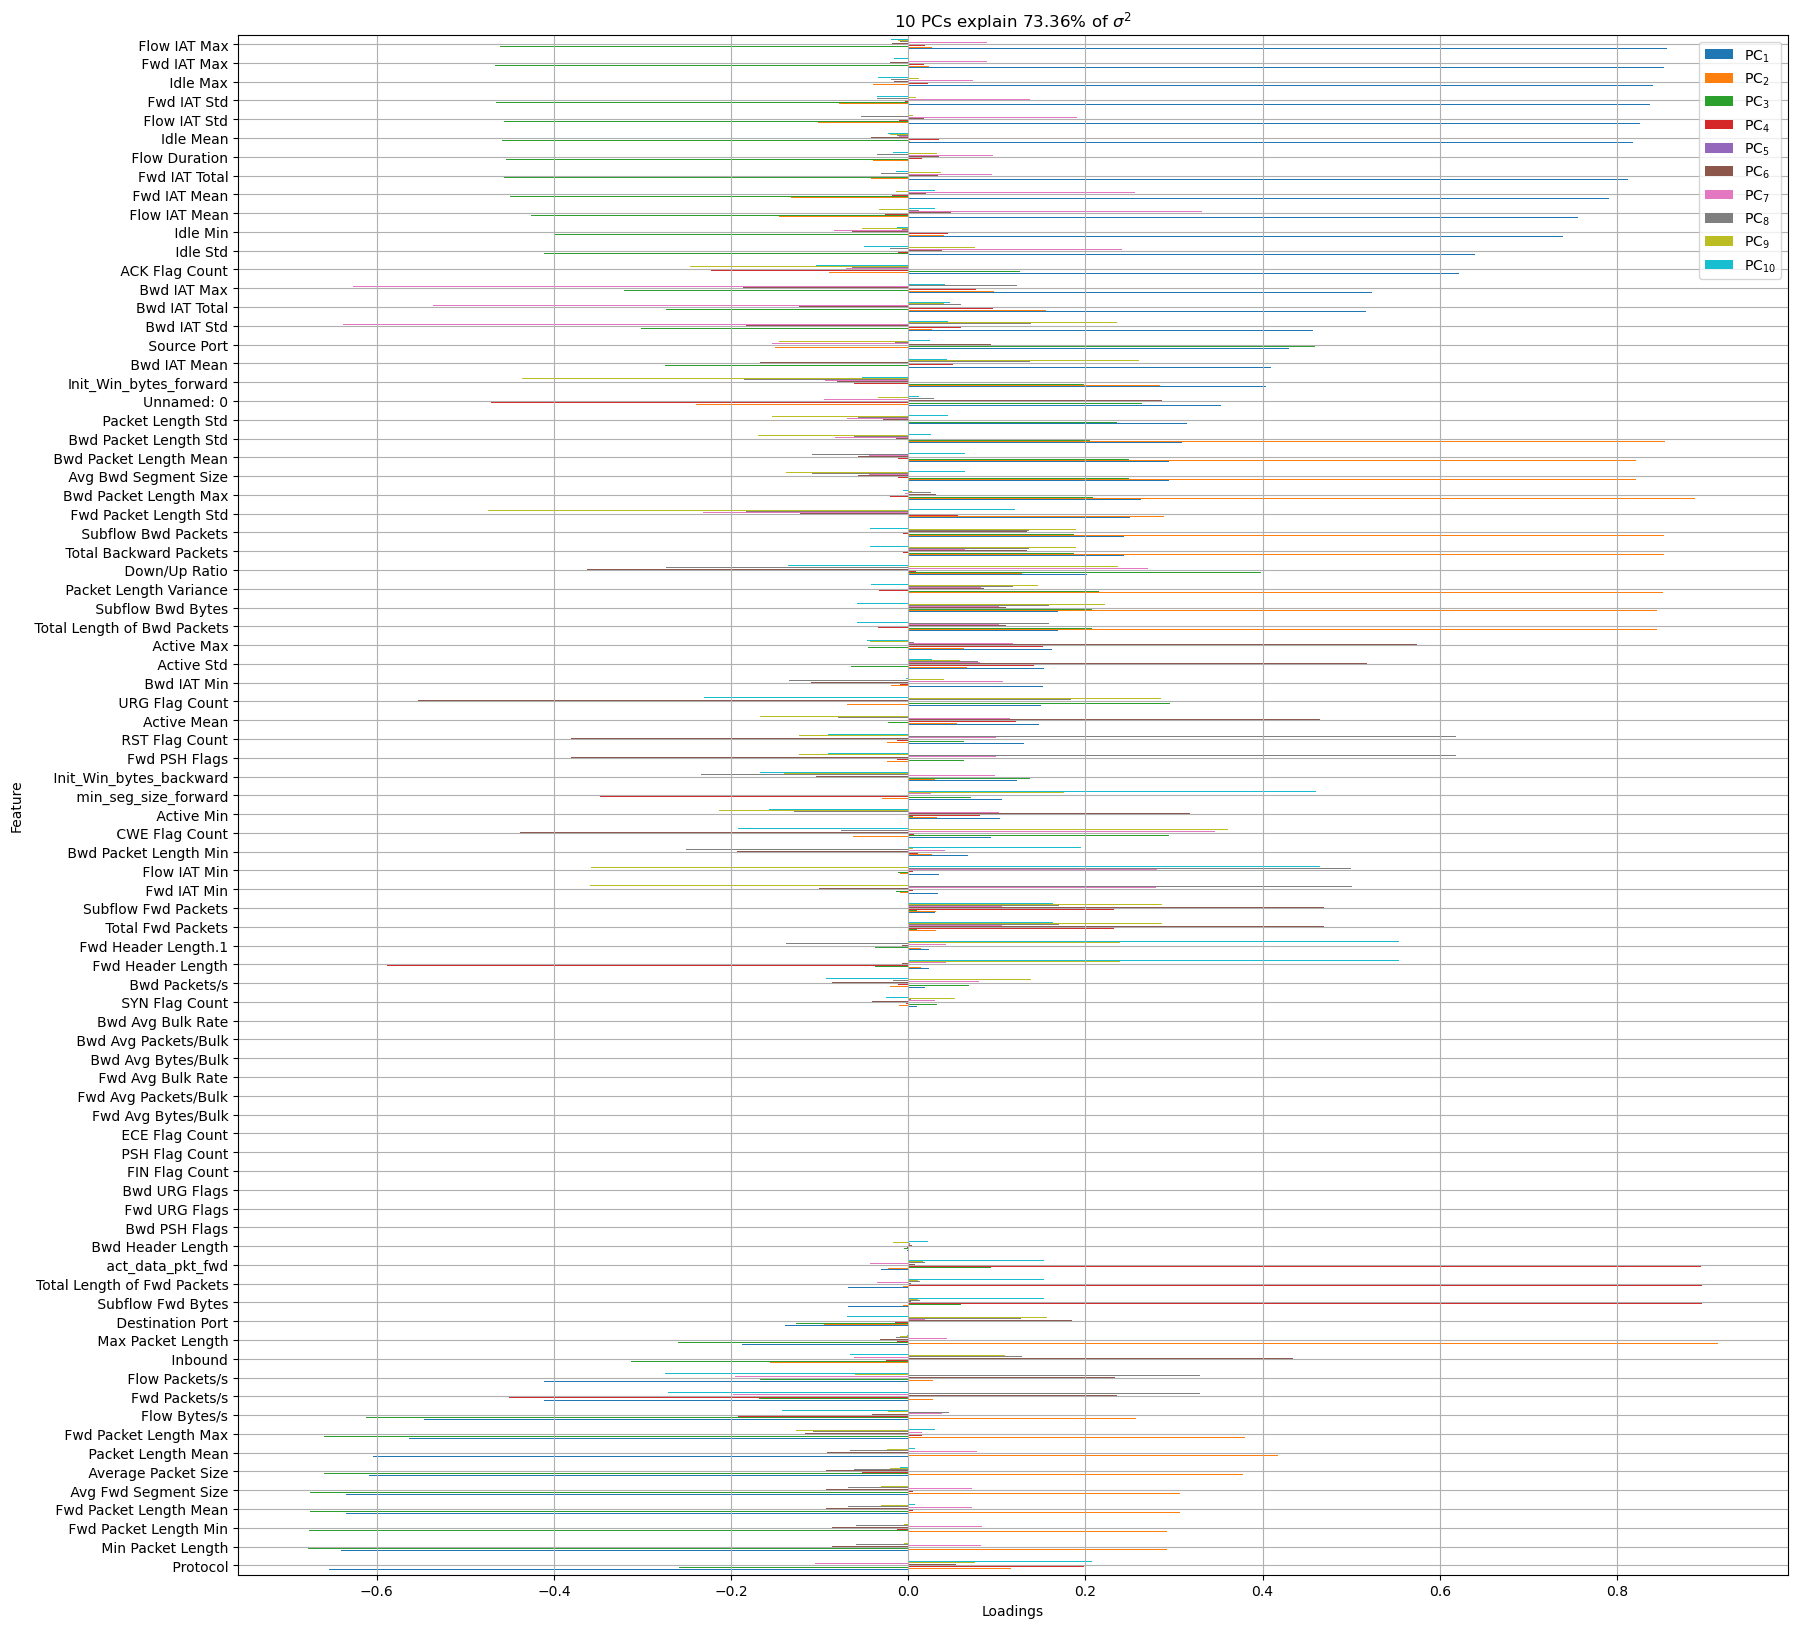

In [36]:
loadings = pd.DataFrame(
    data = pca.components_.T * np.sqrt(pca.explained_variance_), 
    columns = [f'PC{i}' for i in range(1, 11)],
    index = df_scaled.drop(columns=['label', 'Flow ID', ' Source IP', ' Destination IP', 'SimillarHTTP']).columns
)

plt.figure(figsize=(20,20))
loadings = loadings[['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10']]
loadings.sort_values(['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10']).rename(columns={'PC1':'PC$_{1}$', 'PC2':'PC$_{2}$',
        'PC3':'PC$_{3}$', 'PC4':'PC$_{4}$', 'PC5':'PC$_{5}$', 'PC6':'PC$_{6}$', 'PC7':'PC$_{7}$', 'PC8':'PC$_{8}$', 'PC9':'PC$_{9}$', 'PC10':'PC$_{10}$'}).plot.barh(ax=plt.gca())
plt.grid()
plt.xlabel('Loadings')
plt.ylabel('Feature')
plt.title(f'10 PCs explain {round(perc_cumul_exp_var[9], 2)}% of $\sigma^2$')
plt.show()

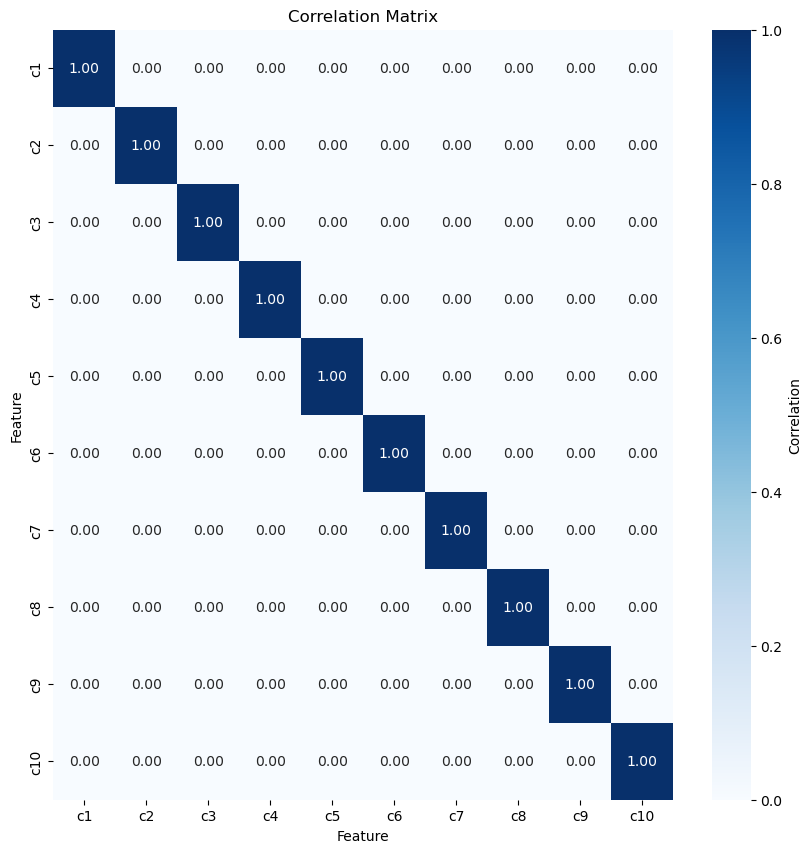

In [43]:
pca_correlation_matrix = pca_df.corr().abs()

plt.figure(figsize=(10,10))
sns.heatmap(pca_correlation_matrix, cmap='Blues', annot=True, vmin=0, vmax=1, cbar_kws={'label':'Correlation'}, fmt='.2f')
plt.xlabel('Feature')
plt.ylabel('Feature')
plt.title('Correlation Matrix')
plt.show()